In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# 设置绘图风格
sns.set(style="whitegrid")
plt.rcParams['font.family'] = 'sans-serif' # 避免中文乱码，绘图主要用英文

# --- 1. 加载数据 ---
# 读取原始数据（包含选手特征：年龄、行业、舞伴等）
# 注意：假设原始数据可能是宽表(Wide)或长表(Long)。这里假设是比赛官方提供的格式
df_raw = pd.read_csv('2026_MCM_Problem_C_Data.csv', encoding='ISO-8859-1')

# 读取任务一生成的观众投票数据
# 假设该文件包含列：['season', 'week', 'celebrity_name', 'estimated_votes']
df_votes = pd.read_csv('task1_reconstructed_votes.csv')

print("Raw Data Shape:", df_raw.shape)
print("Votes Data Shape:", df_votes.shape)
print("\nRaw Columns:", df_raw.columns.tolist()[:5])
print("Votes Columns:", df_votes.columns.tolist())

Raw Data Shape: (421, 53)
Votes Data Shape: (2249, 7)

Raw Columns: ['ï»¿celebrity_name', 'ballroom_partner', 'celebrity_industry', 'celebrity_homestate', 'celebrity_homecountry/region']
Votes Columns: ['Season', 'Week', 'Contestant', 'Judge_Score_Raw', 'Reconstructed_Vote_Share', 'Result_Status', 'Is_Eliminated']


In [4]:
# --- 2. 数据清洗与特征提取 (修正版) ---

# 2.1 彻底清洗列名
def clean_column_names(df):
    # 去除 BOM 字符, 转换为小写, 去除前后空格, 将中间空格替换为下划线
    df.columns = [c.encode('ascii', 'ignore').decode('ascii').strip().lower().replace(' ', '_') for c in df.columns]
    return df

df_raw = clean_column_names(df_raw)
df_votes = clean_column_names(df_votes)

# 打印清洗后的列名，方便你核对
print("Cleaned Raw Columns:", df_raw.columns.tolist())
print("Cleaned Vote Columns:", df_votes.columns.tolist())

# 2.2 自动匹配选手列名
# 有些 CSV 里叫 'celebrity_name'，有些可能只叫 'celebrity' 或 'contestant'
def find_col(possible_names, df_cols):
    for name in possible_names:
        if name in df_cols: return name
    return None

# 这里的 'contestant' 是因为你的 task1 文件里使用了这个名称
raw_name_col = find_col(['celebrity_name', 'celebrity', 'contestant'], df_raw.columns)
vote_name_col = find_col(['contestant', 'celebrity_name', 'celebrity'], df_votes.columns)

if not raw_name_col or not vote_name_col:
    raise ValueError(f"Could not find celebrity name column. Raw: {raw_name_col}, Vote: {vote_name_col}")

# 统一名称以便合并
df_votes = df_votes.rename(columns={vote_name_col: 'celebrity_common'})
df_raw = df_raw.rename(columns={raw_name_col: 'celebrity_common'})

# 2.3 提取特征
# 根据你上传的 raw 数据，确认需要的列
cols_to_keep = ['season', 'celebrity_common', 'ballroom_partner', 
                'celebrity_industry', 'celebrity_age_during_season']

# 只选择存在的列
available_cols = [c for c in cols_to_keep if c in df_raw.columns]
df_features = df_raw[available_cols].drop_duplicates()

# 2.4 清洗“行业” (Industry)
def clean_industry(ind):
    if pd.isna(ind): return 'Other'
    ind = str(ind).lower()
    if any(x in ind for x in ['athlete', 'nfl', 'nba', 'olympic', 'swimmer', 'skater', 'player']):
        return 'Athlete'
    elif any(x in ind for x in ['actor', 'actress', 'movie', 'star']):
        return 'Actor'
    elif any(x in ind for x in ['singer', 'music', 'rapper', 'band']):
        return 'Musician'
    elif any(x in ind for x in ['reality', 'housewife', 'bachelor', 'tv_personality']):
        return 'Reality'
    else:
        return 'Other'

df_features['industry_group'] = df_features['celebrity_industry'].apply(clean_industry)

# 2.5 合并数据
# 注意：两个表的 season 类型要一致（都是 int）
df_votes['season'] = df_votes['season'].astype(int)
df_features['season'] = df_features['season'].astype(int)

df_analysis = pd.merge(df_votes, df_features, on=['season', 'celebrity_common'], how='left')

# 2.6 计算关键指标
# 计算每周得票份额（如果 task1 还没算的话）
if 'reconstructed_vote_share' in df_analysis.columns:
    df_analysis['fan_vote_share'] = df_analysis['reconstructed_vote_share']
else:
    # 如果只有绝对票数，则计算份额
    df_analysis['weekly_total'] = df_analysis.groupby(['season', 'week'])['estimated_votes'].transform('sum')
    df_analysis['fan_vote_share'] = df_analysis['estimated_votes'] / df_analysis['weekly_total']

# 标准化评委分 (使用 task1 里的 judge_score_raw)
df_analysis['judge_zscore'] = df_analysis.groupby('season')['judge_score_raw'].transform(lambda x: (x - x.mean()) / (x.std() + 1e-6))
df_analysis['fan_zscore'] = df_analysis.groupby('season')['fan_vote_share'].transform(lambda x: (x - x.mean()) / (x.std() + 1e-6))

print(f"Merge successful! Final shape: {df_analysis.shape}")
df_analysis.head()

Cleaned Raw Columns: ['celebrity_name', 'ballroom_partner', 'celebrity_industry', 'celebrity_homestate', 'celebrity_homecountry/region', 'celebrity_age_during_season', 'season', 'results', 'placement', 'week1_judge1_score', 'week1_judge2_score', 'week1_judge3_score', 'week1_judge4_score', 'week2_judge1_score', 'week2_judge2_score', 'week2_judge3_score', 'week2_judge4_score', 'week3_judge1_score', 'week3_judge2_score', 'week3_judge3_score', 'week3_judge4_score', 'week4_judge1_score', 'week4_judge2_score', 'week4_judge3_score', 'week4_judge4_score', 'week5_judge1_score', 'week5_judge2_score', 'week5_judge3_score', 'week5_judge4_score', 'week6_judge1_score', 'week6_judge2_score', 'week6_judge3_score', 'week6_judge4_score', 'week7_judge1_score', 'week7_judge2_score', 'week7_judge3_score', 'week7_judge4_score', 'week8_judge1_score', 'week8_judge2_score', 'week8_judge3_score', 'week8_judge4_score', 'week9_judge1_score', 'week9_judge2_score', 'week9_judge3_score', 'week9_judge4_score', 'week1

,season,week,celebrity_common,judge_score_raw,reconstructed_vote_share,result_status,is_eliminated,ballroom_partner,celebrity_industry,celebrity_age_during_season,industry_group,fan_vote_share,judge_zscore,fan_zscore
0,1,2,John O'Hurley,26.0,0.230377,2nd Place,False,Charlotte Jorgensen,Actor/Actress,50.0,Actor,0.230377,1.136285,0.476216
1,1,2,Kelly Monaco,17.0,0.166838,1st Place,False,Alec Mazo,Actor/Actress,29.0,Actor,0.166838,-1.024257,-0.519869
2,1,2,Evander Holyfield,14.0,0.188417,Eliminated Week 3,False,Edyta Sliwinska,Athlete,42.0,Athlete,0.188417,-1.744438,-0.181578
3,1,2,Rachel Hunter,24.0,0.165410,Eliminated Week 4,False,Jonathan Roberts,Model,35.0,Other,0.165410,0.656165,-0.542247
4,1,2,Joey McIntyre,21.0,0.155788,3rd Place,False,Ashly DelGrosso,Singer/Rapper,32.0,Musician,0.155788,-0.064016,-0.693095


In [5]:
# --- 3. 量化职业舞伴影响力 (Pro Dancer Effect) ---

# 计算每个舞伴的平均评委得分 (Judge Rating) 和 平均观众份额 (Fan Rating)
partner_stats = df_analysis.groupby('ballroom_partner').agg({
    'judge_zscore': 'mean',
    'fan_zscore': 'mean',
    'season': 'count' # 参赛次数
}).reset_index()

# 过滤掉只参加过1-2次的舞伴，避免噪音
partner_stats = partner_stats[partner_stats['season'] > 10] # 这里假设样本是周次，调整阈值

partner_stats.rename(columns={
    'judge_zscore': 'partner_hist_judge_perf', 
    'fan_zscore': 'partner_hist_fan_perf'
}, inplace=True)

# 将舞伴的历史能力值合并回主表
df_model = pd.merge(df_analysis, partner_stats[['ballroom_partner', 'partner_hist_judge_perf', 'partner_hist_fan_perf']], 
                    on='ballroom_partner', how='left')

# 填充缺失值（新舞伴用平均值填充）
df_model['partner_hist_judge_perf'].fillna(0, inplace=True)
df_model['partner_hist_fan_perf'].fillna(0, inplace=True)

C:\Users\luhua\AppData\Local\Temp\ipykernel_75112\2456554926.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_model['partner_hist_judge_perf'].fillna(0, inplace=True)
C:\Users\luhua\AppData\Local\Temp\ipykernel_75112\2456554926.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c

In [7]:
# --- 4. 建立回归模型 (OLS) ---

# 1. 确保所有特征都是数值型
# 将 industry 转换为 0/1 (通过 dtype=int 强制转换)
dummy_industry = pd.get_dummies(df_model['industry_group'], prefix='ind', drop_first=True, dtype=int)

# 2. 定义自变量列表
# 基础特征 + 舞伴特征 + 行业特征
feature_cols = ['celebrity_age_during_season', 'partner_hist_judge_perf', 'partner_hist_fan_perf']
# 获取 dummy 所有的列名
industry_cols = dummy_industry.columns.tolist()
all_features = feature_cols + industry_cols

# 3. 准备建模数据集
# 合并 dummy 到主表
df_reg_prep = pd.concat([df_model, dummy_industry], axis=1)

# 定义目标变量
targets = ['judge_zscore', 'fan_zscore']

# 4. 关键步骤：清理数据
# 确保年龄是数值，非数值转为 NaN
df_reg_prep['celebrity_age_during_season'] = pd.to_numeric(df_reg_prep['celebrity_age_during_season'], errors='coerce')

# 只保留没有缺失值的行 (目标变量 + 自变量)
df_reg = df_reg_prep.dropna(subset=targets + all_features)

# 5. 提取 X 和 Y
X = df_reg[all_features].copy()
# 再次强制转换 X 的所有列为 float，彻底杜绝 "object" 类型问题
X = X.astype(float) 

# 添加常数项 (截距)
X = sm.add_constant(X)

# --- 运行模型 ---

# 模型 A: 预测评委偏好
model_judge = sm.OLS(df_reg['judge_zscore'], X).fit()

# 模型 B: 预测观众偏好
model_fan = sm.OLS(df_reg['fan_zscore'], X).fit()

# 6. 提取结果对比
res_compare = pd.DataFrame({
    'Feature': X.columns,
    'Judge_Coeff': model_judge.params,
    'Judge_Pval': model_judge.pvalues,
    'Fan_Coeff': model_fan.params,
    'Fan_Pval': model_fan.pvalues
}).reset_index(drop=True)

# 过滤掉截距项 (const)
res_compare = res_compare[res_compare['Feature'] != 'const']

# 格式化输出：只保留显著或重要的特征看一眼
print("--- Regression Coefficients (Impact Analysis) ---")
print(res_compare.round(4))

# 检查是否存在全为0或NaN的情况
if res_compare.empty:
    print("Warning: res_compare is empty. Check if data was dropped during dropna().")

--- Regression Coefficients (Impact Analysis) ---
                       Feature  Judge_Coeff  Judge_Pval  Fan_Coeff  Fan_Pval
1  celebrity_age_during_season      -0.0245      0.0000    -0.0177    0.0000
2      partner_hist_judge_perf       0.6409      0.0001    -0.2395    0.1517
3        partner_hist_fan_perf       0.0491      0.8220     1.0097    0.0000
4                  ind_Athlete      -0.1566      0.0039    -0.0577    0.3121
5                 ind_Musician      -0.0186      0.7546     0.0233    0.7111
6                    ind_Other      -0.2790      0.0000    -0.1255    0.0134


<Figure size 1200x600 with 0 Axes>

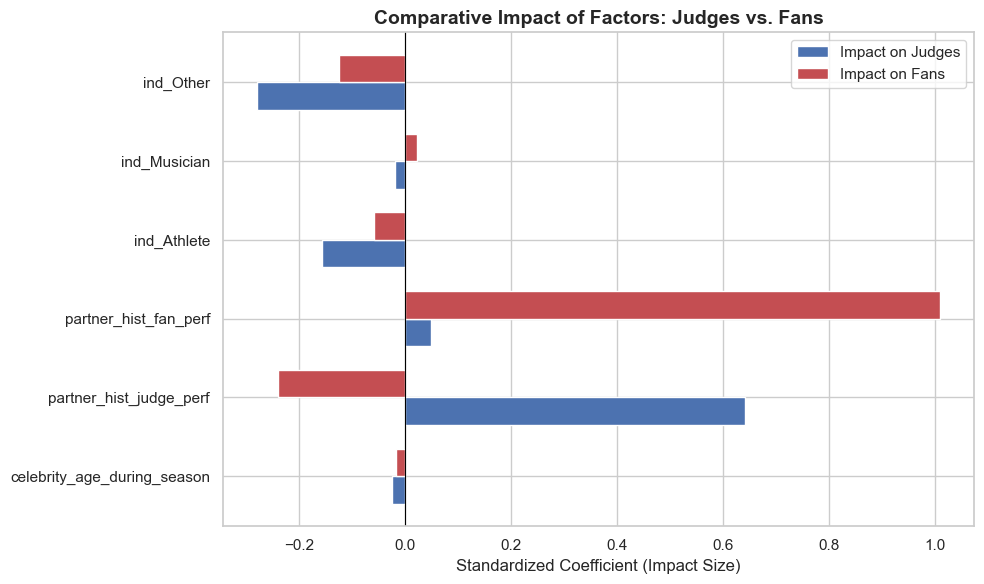

C:\Users\luhua\AppData\Local\Temp\ipykernel_75112\3111884744.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='industry_group', y='judge_zscore', data=df_model, palette='Blues')
C:\Users\luhua\AppData\Local\Temp\ipykernel_75112\3111884744.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='industry_group', y='fan_zscore', data=df_model, palette='Reds')


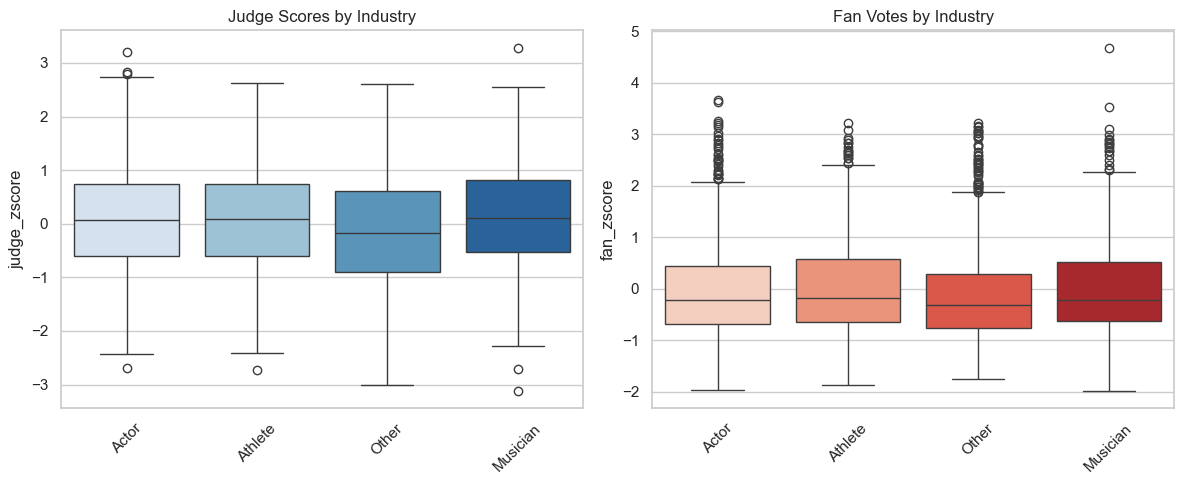

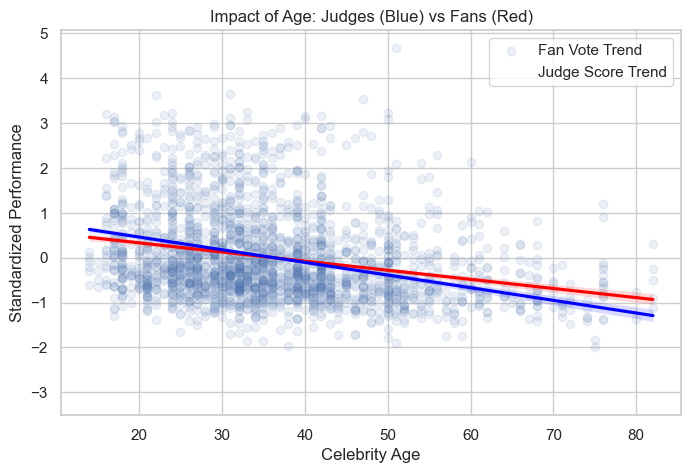

In [8]:
# --- 5. 结果可视化 ---

# 图 1: 蝴蝶图 (Butterfly Chart) - 对比评委与观众的偏好差异
plt.figure(figsize=(12, 6))

# 数据准备
features = res_compare['Feature']
judge_vals = res_compare['Judge_Coeff']
fan_vals = res_compare['Fan_Coeff']

y = np.arange(len(features))
height = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.barh(y - height/2, judge_vals, height, label='Impact on Judges', color='#4c72b0')
rects2 = ax.barh(y + height/2, fan_vals, height, label='Impact on Fans', color='#c44e52')

ax.set_yticks(y)
ax.set_yticklabels(features)
ax.set_xlabel('Standardized Coefficient (Impact Size)')
ax.set_title('Comparative Impact of Factors: Judges vs. Fans', fontsize=14, fontweight='bold')
ax.legend()
ax.axvline(0, color='black', linewidth=0.8)

plt.tight_layout()
plt.show()

# 图 2: 行业表现箱线图
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='industry_group', y='judge_zscore', data=df_model, palette='Blues')
plt.title('Judge Scores by Industry')
plt.xticks(rotation=45)
plt.xlabel('')

plt.subplot(1, 2, 2)
sns.boxplot(x='industry_group', y='fan_zscore', data=df_model, palette='Reds')
plt.title('Fan Votes by Industry')
plt.xticks(rotation=45)
plt.xlabel('')

plt.tight_layout()
plt.show()

# 图 3: 年龄影响散点图
plt.figure(figsize=(8, 5))
sns.regplot(x='celebrity_age_during_season', y='fan_zscore', data=df_model, 
            scatter_kws={'alpha':0.1}, line_kws={'color':'red'}, label='Fan Vote Trend')
sns.regplot(x='celebrity_age_during_season', y='judge_zscore', data=df_model, 
            scatter_kws={'alpha':0}, line_kws={'color':'blue'}, label='Judge Score Trend')
plt.legend()
plt.title('Impact of Age: Judges (Blue) vs Fans (Red)')
plt.xlabel('Celebrity Age')
plt.ylabel('Standardized Performance')
plt.show()

In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import shap
import matplotlib.pyplot as plt

# 1. 准备特征矩阵 X 和目标变量 y
# 我们预测的是 'fan_zscore' (观众偏好)
# 也可以换成 'judge_zscore' 进行对比分析
X_shap = df_reg[all_features].copy()
y_shap = df_reg['fan_zscore']

# 2. 训练随机森林模型
# n_estimators: 树的数量；max_depth: 深度，避免过拟合
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_shap, y_shap)

print("随机森林模型训练完成。")
print(f"模型 R^2 得分: {rf_model.score(X_shap, y_shap):.4f}")

随机森林模型训练完成。
模型 R^2 得分: 0.2888


In [10]:
# 3. 初始化 SHAP 解释器
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_shap)

# 注意：在某些 shap 版本中，对于回归问题，shap_values 直接就是数组
# 如果是多分类，它会是列表。这里我们处理回归。
print("SHAP 值计算完成。")

SHAP 值计算完成。


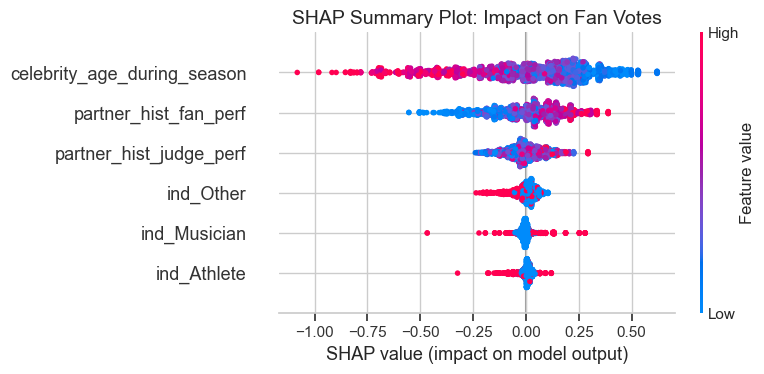

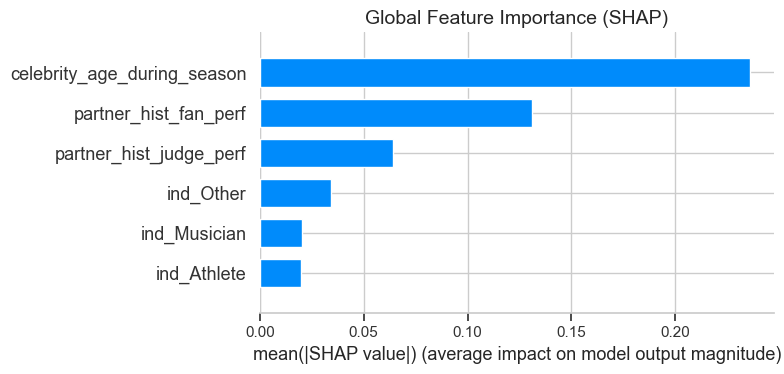

<Figure size 800x500 with 0 Axes>

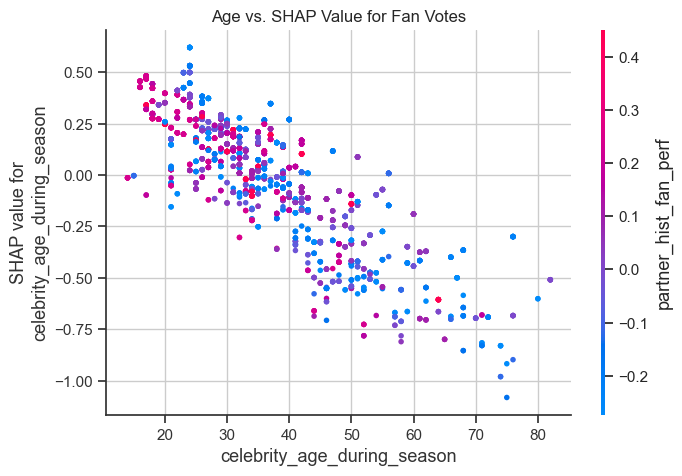

In [11]:
# --- 4. 可视化 ---

# 图 A: 特征重要性摘要图 (Summary Plot - Beeswarm)
# 这种图能显示特征对预测的正向或负向影响
plt.figure(figsize=(10, 6))
plt.title("SHAP Summary Plot: Impact on Fan Votes", fontsize=14)
shap.summary_plot(shap_values, X_shap, show=False)
plt.tight_layout()
plt.show()

# 图 B: 特征重要性条形图 (Global Importance)
plt.figure(figsize=(10, 6))
plt.title("Global Feature Importance (SHAP)", fontsize=14)
shap.summary_plot(shap_values, X_shap, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

# 图 C: 依赖图 (Dependence Plot) - 以年龄为例
# 展示年龄的变化如何具体影响 SHAP 值
plt.figure(figsize=(8, 5))
shap.dependence_plot("celebrity_age_during_season", shap_values, X_shap, show=False)
plt.title("Age vs. SHAP Value for Fan Votes", fontsize=12)
plt.show()

C:\Users\luhua\AppData\Local\Temp\ipykernel_75112\869662263.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(x_range, model_base.params[0] + model_base.params[1] * x_range, color='red', linestyle='--')
C:\Users\luhua\AppData\Local\Temp\ipykernel_75112\869662263.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_res, x='ind_group', y='controversy_index', palette='Set2')


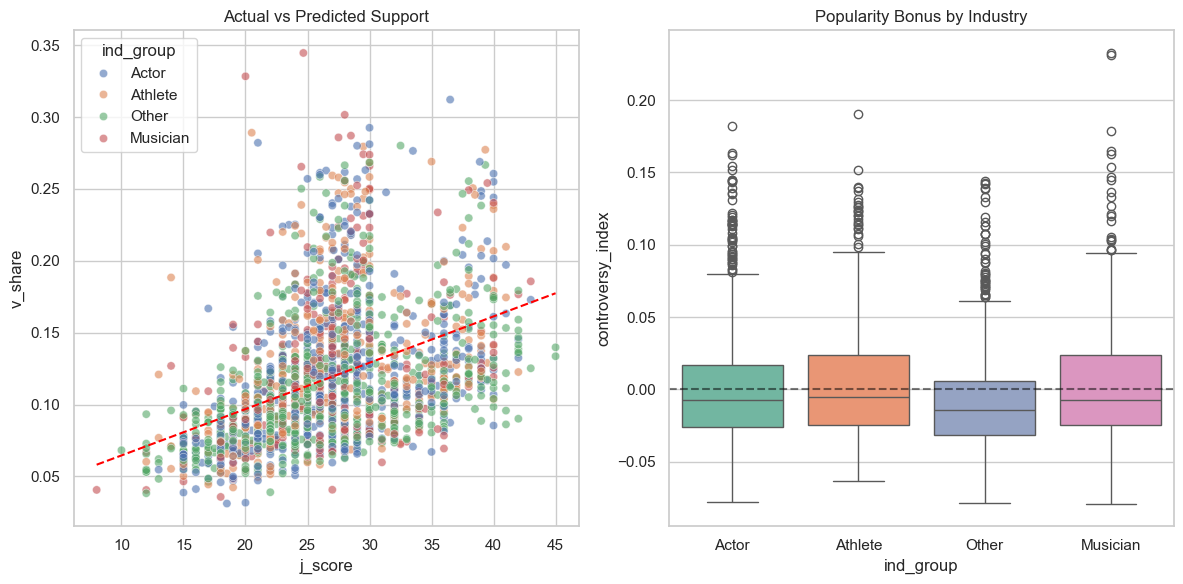

最具观众缘（残差最高）的前5名选手：
         celeb_key  j_score   v_share  controversy_index
536   Donny Osmond  24.6666  0.344587           0.232672
14   Joey McIntyre  20.0000  0.328326           0.231453
62      Jerry Rice  20.5000  0.289108           0.190623
11   John O'Hurley  21.0000  0.282104           0.182007
249   Marie Osmond  28.0000  0.301555           0.178896


In [14]:
#争议性分析:我们已知评委分代表了选手的“硬实力”。用评委分去预测观众投票。残差 (Residual) = 实际投票 - 预测投票。如果残差为正且很大，说明这个选手拥有超越其舞蹈水平的“观众缘”或“争议性”。
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. 数据加载 ---
df_raw = pd.read_csv('2026_MCM_Problem_C_Data.csv', encoding='ISO-8859-1')
df_votes = pd.read_csv('task1_reconstructed_votes.csv')

# 自动清洗所有列名（去除空格、转小写）
df_raw.columns = [c.strip().lower() for c in df_raw.columns]
df_votes.columns = [c.strip().lower() for c in df_votes.columns]

# --- 2. 智能探测列名 ---
def get_col_name(df, patterns):
    for p in patterns:
        for col in df.columns:
            if p in col:
                return col
    return None

# 寻找选手名列
raw_name_col = get_col_name(df_raw, ['celebrity_name', 'contestant', 'celebrity'])
vote_name_col = get_col_name(df_votes, ['contestant', 'celebrity_name', 'celebrity'])

# 寻找评委分列
raw_score_col = get_col_name(df_votes, ['judge_score_raw', 'judge_score', 'score'])
# 寻找投票份额列
vote_share_col = get_col_name(df_votes, ['reconstructed_vote_share', 'vote_share', 'share'])

if not raw_name_col or not vote_name_col:
    print(f"Error: 找不到选手名列。Raw列名: {df_raw.columns.tolist()}")
else:
    # 统一命名
    df_raw = df_raw.rename(columns={raw_name_col: 'celeb_key', 'celebrity_industry': 'industry'})
    df_votes = df_votes.rename(columns={vote_name_col: 'celeb_key', 
                                        raw_score_col: 'j_score', 
                                        vote_share_col: 'v_share'})

    # --- 3. 提取特征并合并 ---
    # 提取必要的列，注意有些列名在你的 CSV 里可能有细微差别
    df_feat = df_raw[['season', 'celeb_key', 'industry']].drop_duplicates()
    df_res = pd.merge(df_votes, df_feat, on=['season', 'celeb_key'], how='left')

    # --- 4. 准备回归变量 ---
    df_res['j_score'] = pd.to_numeric(df_res['j_score'], errors='coerce')
    df_res['v_share'] = pd.to_numeric(df_res['v_share'], errors='coerce')
    df_res = df_res.dropna(subset=['j_score', 'v_share'])

    # 简化的行业分组逻辑
    def group_ind(x):
        x = str(x).lower()
        if any(i in x for i in ['athlete', 'nfl', 'nba']): return 'Athlete'
        if any(i in x for i in ['actor', 'actress']): return 'Actor'
        if any(i in x for i in ['singer', 'music']): return 'Musician'
        return 'Other'
    
    df_res['ind_group'] = df_res['industry'].apply(group_ind)

    # --- 5. 计算争议性残差 ---
    X = sm.add_constant(df_res['j_score'])
    model_base = sm.OLS(df_res['v_share'], X).fit()
    df_res['controversy_index'] = model_base.resid

    # --- 6. 可视化 ---
    plt.figure(figsize=(12, 6))
    
    # 子图1：散点图与回归线
    plt.subplot(1, 2, 1)
    sns.scatterplot(data=df_res, x='j_score', y='v_share', hue='ind_group', alpha=0.6)
    x_range = np.linspace(df_res['j_score'].min(), df_res['j_score'].max(), 100)
    plt.plot(x_range, model_base.params[0] + model_base.params[1] * x_range, color='red', linestyle='--')
    plt.title("Actual vs Predicted Support")

    # 子图2：行业加成
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df_res, x='ind_group', y='controversy_index', palette='Set2')
    plt.axhline(0, color='black', linestyle='--', alpha=0.5)
    plt.title("Popularity Bonus by Industry")
    
    plt.tight_layout()
    plt.show()

    # 输出争议选手
    top_dogs = df_res.sort_values('controversy_index', ascending=False).head(5)
    print("最具观众缘（残差最高）的前5名选手：")
    print(top_dogs[['celeb_key', 'j_score', 'v_share', 'controversy_index']])